In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/content/ibm_stock_prices_2000_2025.csv')
df = df[['Close', 'High', 'Low', 'Open']]
df

,Close,High,Low,Open
0,IBM,IBM,IBM,IBM
1,NaN,NaN,NaN,NaN
2,58.50724792480469,58.50724792480469,56.42671333176599,56.71042039896029
3,56.5212516784668,57.750660377617265,55.92230949491503,57.49847377137779
4,58.50724792480469,60.3986484981173,56.55280670332016,56.96260714206864
...,...,...,...,...
6367,229.3300018310547,232.77999877929688,224.44000244140625,231.17999267578125
6368,232.41000366210938,233.36000061035156,226.32000732421875,228.9499969482422
6369,236.16000366210938,236.6300048828125,232.07000732421875,232.86000061035156
6370,239.38999938964844,239.97999572753906,236.13999938964844,237.0


In [3]:
df = df.drop(index=[0, 1]).reset_index(drop=True)

In [ ]:
df

,Close,High,Low,Open
0,58.50724792480469,58.50724792480469,56.42671333176599,56.71042039896029
1,56.5212516784668,57.750660377617265,55.92230949491503,57.49847377137779
2,58.50724792480469,60.3986484981173,56.55280670332016,56.96260714206864
3,57.49849319458008,59.9888317411055,57.24630650315101,59.515982700943326
4,57.246299743652344,59.484451334473405,55.79622845169062,59.1376956809698
...,...,...,...,...
6365,229.3300018310547,232.77999877929688,224.44000244140625,231.17999267578125
6366,232.41000366210938,233.36000061035156,226.32000732421875,228.9499969482422
6367,236.16000366210938,236.6300048828125,232.07000732421875,232.86000061035156
6368,239.38999938964844,239.97999572753906,236.13999938964844,237.0


In [4]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

In [5]:
seq_length = 20
num_features = 4
X,y = create_sequence(df, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5096, 20, 4) (1254, 20, 4) (5096,) (1254,)


In [6]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.fit_transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.fit_transform(y_test.reshape(-1,1))

In [7]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5096, 20, 4]) torch.Size([1254, 20, 4]) torch.Size([5096, 1]) torch.Size([1254, 1])


#define model

In [9]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUmodel, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])
    return out

In [14]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [15]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = GRUmodel(input_size = num_features, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [16]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam', 'sgd']

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model

Streaming output truncated to the last 5000 lines.
Epoch [1/10], Loss: 0.0378
Epoch [1/10], Loss: 0.0272
Epoch [1/10], Loss: 0.0323
Epoch [1/10], Loss: 0.0305
Epoch [1/10], Loss: 0.0124
Epoch [1/10], Loss: 0.0148
Epoch [1/10], Loss: 0.0198
Epoch [1/10], Loss: 0.0191
Epoch [1/10], Loss: 0.0134
Epoch [1/10], Loss: 0.0052
Epoch [1/10], Loss: 0.0016
Epoch [1/10], Loss: 0.0013
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0005
Epoch [1/10], Loss: 0.0004
Epoch [1/10], Loss: 0.0019
Epoch [1/10], Loss: 0.0020
Epoch [1/10], Loss: 0.0003
Epoch [1/10], Loss: 0.0016
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0030
Epoch [1/10], Loss: 0.0045
Epoch [1/10], Loss: 0.0057
Epoch [1/10], Loss: 0.0026
Epoch [1/10], Loss: 0.0011
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0008
Epoch [1/10], Loss: 0.0054
Epoch [1/10], Loss: 0.0066
Epoch [1/10], Loss: 0.0103
Epoch [1/10], Loss: 0.0128
Epoch [1/10], Loss: 0.0138
Epoch [1/10], Loss: 0.0012
Epoch [1/10], Loss: 0.0006
Epoch [1/10], Loss: 0.0003
Epoc

Best MSE: 0.0006401324062608182
Best Params: {'neurons': 200, 'optimizer': 'adam'}
MSE: 0.0006401322898454964


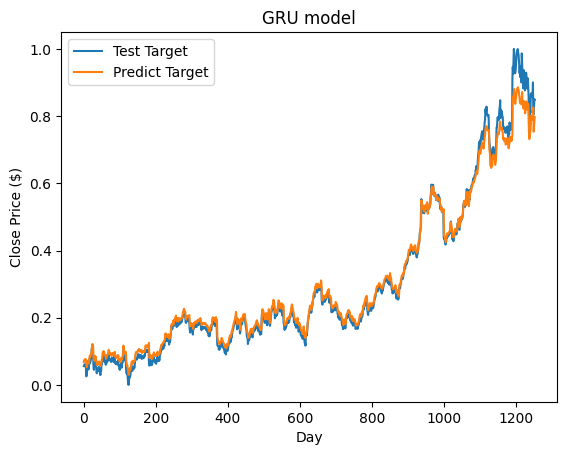

In [17]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("GRU model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()